```markdown
MACHINE LEARNING EMG PROJECT
```
``
Project Workflow
``
`
Data pre-processing
`
Feature Design
`
Develelopment of Models
`
Training
`

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC




#  Data Cleaning

In [2]:
#readin in the data
df = pd.read_csv('Project_Data_EE4C12_S&S_EMG.csv')
classes=np.array([
    'unmarked data',
    'hand at rest',
    'hand clenched in a fist',
    'wrist flexion',
    'wrist extension',
    'radial deviations',
    'ulnar deviations',
    'extended palm'
])

print(df.head())
print(df.shape)
num_samples = df.shape[0]



   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


`
check for n/a values
`

In [3]:
na_counts = df.isna().sum()
display(na_counts.T)

time        0
channel1    0
channel2    0
channel3    0
channel4    0
channel5    0
channel6    0
channel7    0
channel8    0
class       0
label       0
dtype: int64

In [4]:

print("There are " + str(df['label'].nunique()) + " unique subjects in the dataset (different people performing the gestures).")
grouped_df = df.groupby(['label', 'class']).size().unstack(fill_value=0)
display(grouped_df.T)

There are 36 unique subjects in the dataset (different people performing the gestures).


label,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
class,,,,,,,,,,,,,,,,,,,,,
0,78682,94654,67770,72578,68057,61128,82641,80264,90407,81875,...,64660,64522,64093,98180,53642,75148,73298,85693,60383,65538
1,7311,7140,6443,6471,6506,5814,7523,6468,7083,7690,...,7167,5232,6317,8047,6924,6650,7082,7553,6703,6391
2,6806,6777,6301,6598,6806,6243,7651,6537,6019,6571,...,6686,5628,6460,7279,5975,8085,6316,7458,6247,6093
3,7329,6815,6486,6875,6874,6663,8383,5939,5838,6534,...,6654,5488,7495,7480,6197,8271,6127,7274,6422,6078
4,6824,6812,6421,7193,6724,6688,8923,6027,5776,6766,...,7309,5733,7059,7061,6180,8386,6527,7732,6653,5926
5,7075,6856,6278,7423,6098,7094,8414,6237,6050,6658,...,7405,5245,7261,6700,6028,8604,6225,7710,6897,5743
6,7143,7372,6086,7060,6183,5989,9105,6476,6474,6995,...,6918,5918,7302,7223,6077,7786,6530,7782,6196,5985
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6591,0,0,0,0,0,0


Percentage of samples for each class relative to the total number of samples:

Percentage of samples for class 0 relative to the total number of samples: 64.30%
Percentage of samples for class 1 relative to the total number of samples: 5.90%
Percentage of samples for class 2 relative to the total number of samples: 5.74%
Percentage of samples for class 3 relative to the total number of samples: 5.89%
Percentage of samples for class 4 relative to the total number of samples: 5.94%
Percentage of samples for class 5 relative to the total number of samples: 5.94%
Percentage of samples for class 6 relative to the total number of samples: 5.97%
Percentage of samples for class 7 relative to the total number of samples: 0.32%


Number of nonzero elements for class 7: 2, for patients (array([10, 29]),)


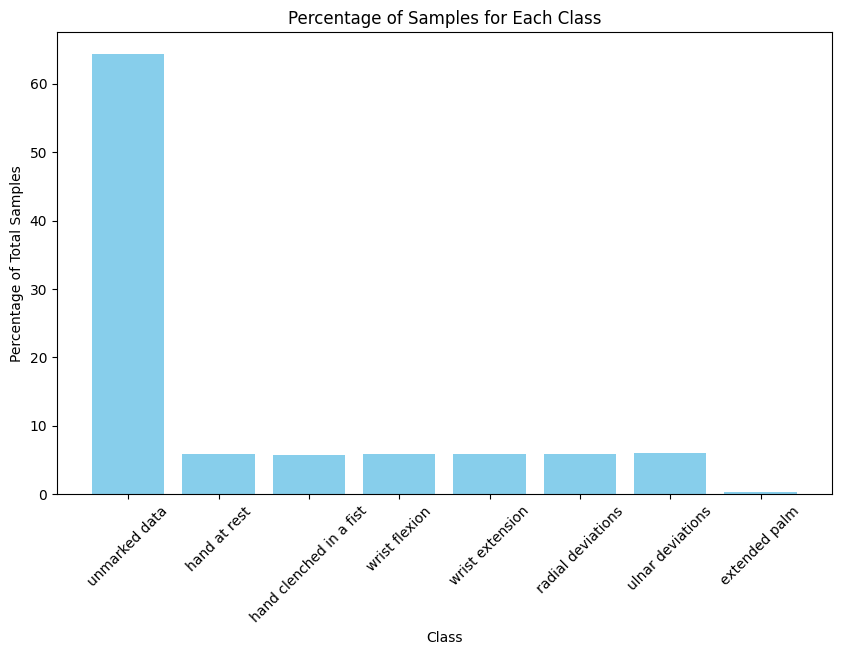

In [5]:
nonzero_count = np.count_nonzero(grouped_df.T.iloc[7])
print(f"Percentage of samples for each class relative to the total number of samples:\n")
for i in range(8):
    nonzero_count = np.count_nonzero(grouped_df.T.iloc[i])
    print(f"Percentage of samples for class {i} relative to the total number of samples: {np.sum(grouped_df.T.iloc[i])/num_samples*100:.2f}%")

print(f"\n\nNumber of nonzero elements for class {i}: {nonzero_count}, for patients {np.nonzero(grouped_df.T.iloc[7])}")

# Calculate the percentages
percentages = [np.sum(grouped_df.T.iloc[i]) / num_samples * 100 for i in range(8)]
# Plot the percentages
plt.figure(figsize=(10, 6))
plt.bar(classes[:8], percentages, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Percentage of Total Samples')
plt.title('Percentage of Samples for Each Class')
plt.xticks(rotation=45)
plt.show()


`
Due to the limited information available on class 7 it was decided that we would only classify on the first 6 classes
`

1499054
Percentage of samples for class 0 relative to the total number of samples: 16.68%
Percentage of samples for class 1 relative to the total number of samples: 16.22%
Percentage of samples for class 2 relative to the total number of samples: 16.64%
Percentage of samples for class 3 relative to the total number of samples: 16.78%
Percentage of samples for class 4 relative to the total number of samples: 16.79%
Percentage of samples for class 5 relative to the total number of samples: 16.88%


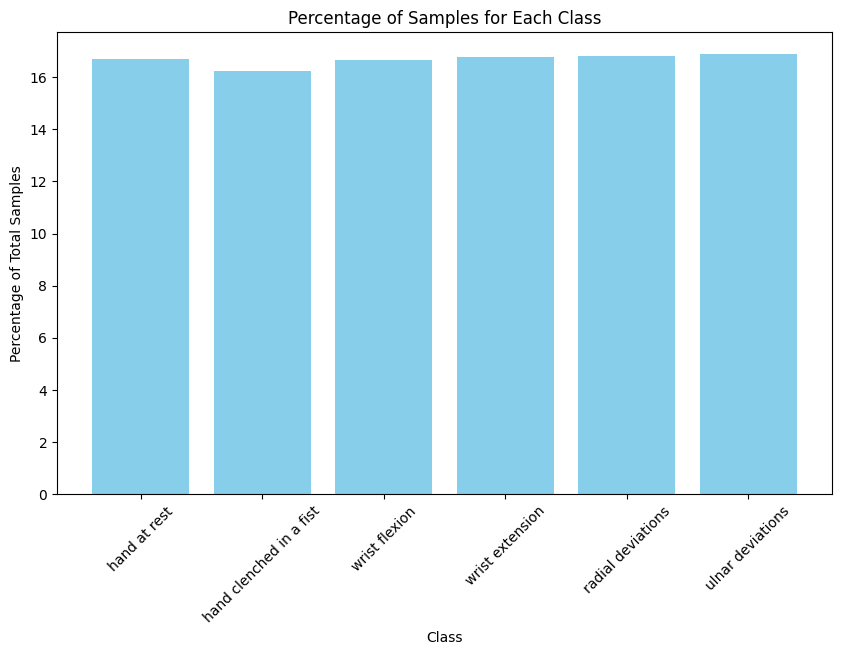

In [6]:

df_preprocessed = df[df['class'] != 7]
df_preprocessed = df_preprocessed[df_preprocessed['class'] != 0]
num_samples_processed = df_preprocessed.shape[0]
print(num_samples_processed)
grouped_df_preprocess = df_preprocessed.groupby([ 'class']).size()
classes_preprocessed = classes[1:7]
for i in range(6):
    # nonzero_count = np.count_nonzero(grouped_df_preprocess.T.iloc[i])
  
    print(f"Percentage of samples for class {i} relative to the total number of samples: {(grouped_df_preprocess.T.iloc[i])/num_samples_processed*100:.2f}%")

#  Calculate the percentages
percentages = [np.sum(grouped_df_preprocess.T.iloc[i]) / num_samples_processed * 100 for i in range(0,6)]
# Plot the percentages
plt.figure(figsize=(10, 6))
plt.bar(classes_preprocessed, percentages, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Percentage of Total Samples')
plt.title('Percentage of Samples for Each Class')
plt.xticks(rotation=45)
plt.show()

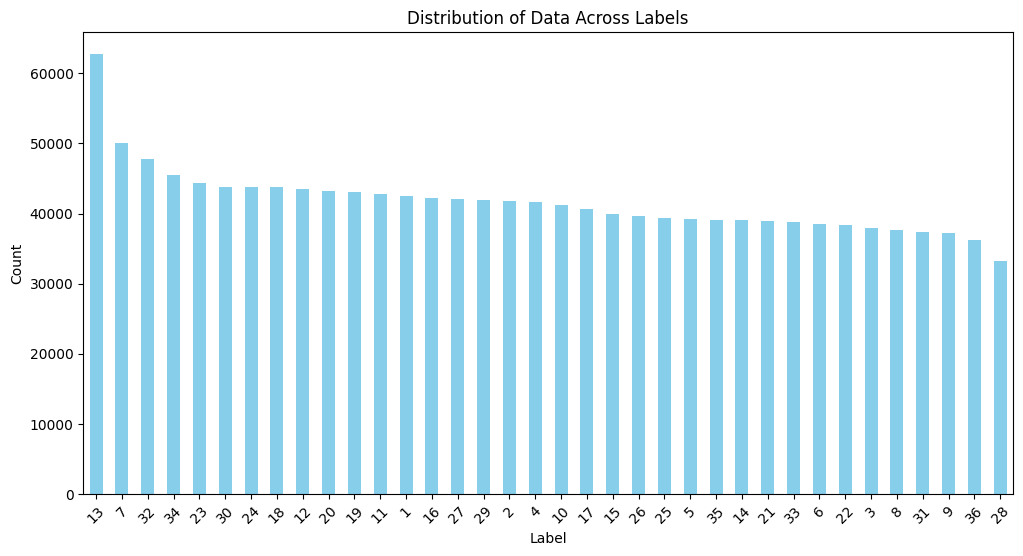

In [7]:
# Count the occurrences of each label
label_counts = df_preprocessed['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Data Across Labels')
plt.xticks(rotation=45)
plt.show()

``
Lets us visualise the data
``

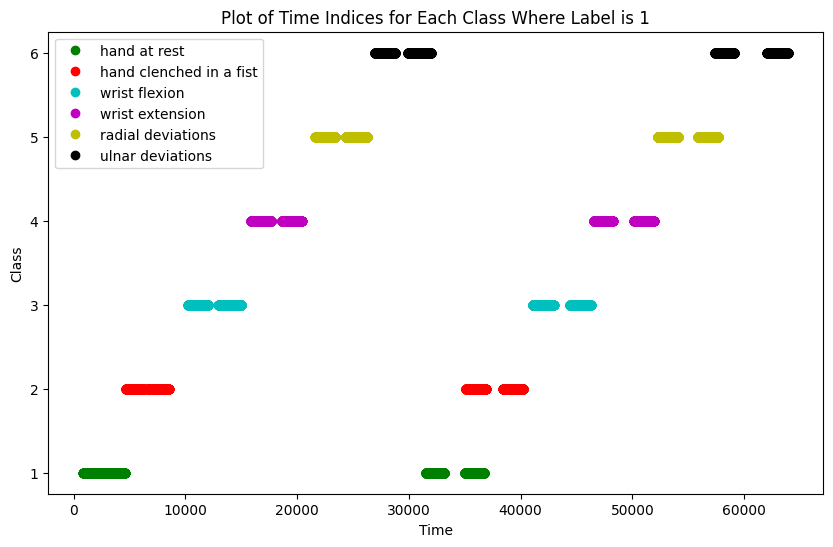

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
64012,880,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64013,881,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64014,882,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64015,883,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
64016,884,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4397,4576,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4398,4577,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4399,4578,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1
4400,4579,-0.00002,0.00002,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,1,1


In [8]:
# Define the colors for each class
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate through each class and plot the markers
for class_value in range(1,7,1):  # Classes are labeled from 0 to 7
    subset = df_preprocessed[(df_preprocessed['label'] == 1) & (df_preprocessed['class'] == class_value) ]#& (df_preprocessed['time'] > 33000)
    plt.plot(subset['time'], subset['class'], 'o', label=f'Class {class_value}', color=colors[class_value])

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Class')
plt.title('Plot of Time Indices for Each Class Where Label is 1')
plt.legend(classes_preprocessed)
plt.show()


subset = df_preprocessed[(df_preprocessed['label'] == 1) & (df_preprocessed['class'] == 1) & (df_preprocessed['time'] < 10000)]
subset = subset.sort_values(by='time')
subset

# Feature extraction/selection

### Window each gesture 
#### separate gestures if there is a gap in time

In [9]:
#loop through 36 labels (subjects)
#separate dataframe parts based on the 6 classes, 
# separate gesture data if there is a time gap between data (empty space)
# save the data in a dictionary with the label and class as the key

# Initialize an empty dictionary to store the separated data
data_dict = {}

# Define the time gap threshold (adjust as needed)
time_gap_threshold = 70000  # Example threshold

# Loop through each label (subject)
for label in range(1,37):
    # Loop through each class
    for class_value in range(1,7,1):
        # Filter the DataFrame for the current label and class
        subset = df_preprocessed[(df_preprocessed['label'] == label) & (df_preprocessed['class'] == class_value)]
        
        # Sort by time to ensure proper segmentation
        subset = subset.sort_values(by='time')
        
        # Identify segments of data where there is a time gap
        segments = []
        current_segment = []
        previous_time = None
        
        for _, row in subset.iterrows():
            current_time = row['time']
            if previous_time is not None and (current_time - previous_time) > time_gap_threshold:
                # Save the current segment and start a new one
                if current_segment:
                    segments.append(pd.DataFrame(current_segment))
                current_segment = []
            current_segment.append(row)
            previous_time = current_time
        
        # Add the last segment if it exists
        if current_segment:
            segments.append(pd.DataFrame(current_segment))
        # if len(segments)!=2:
        #     print(label, class_value,"  segment length is:",len(segments))
        # Save the segments in the dictionary with the label and class as the key
        # Drop the 'time' column from each segment
        # segments = [segment.drop(columns=['time']) for segment in segments]
        
        # Save the segments in the dictionary with the label and class as the key
        data_dict[(label, class_value)] = segments

# data_dict now contains the separated data for each label and class

## ensure segments properly retained by visualising data again

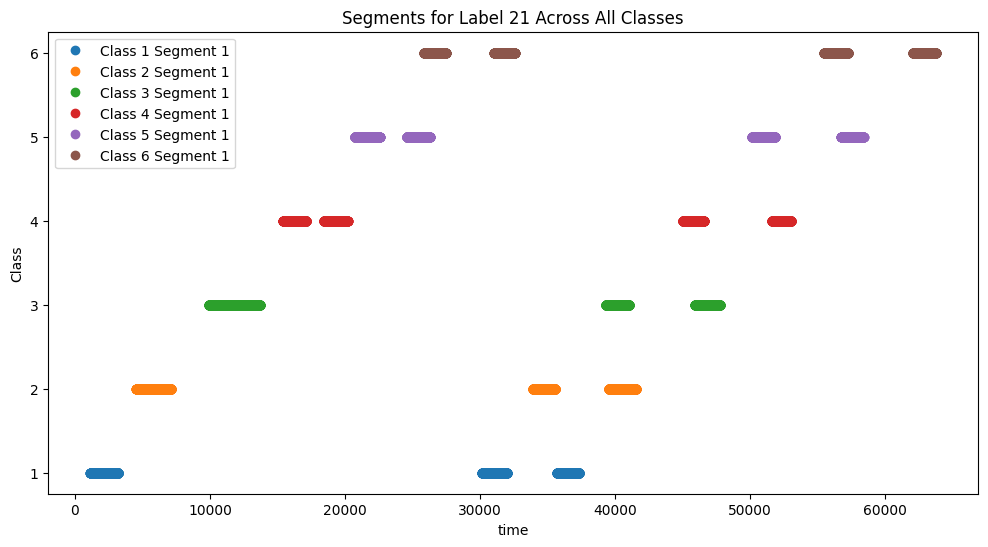

In [10]:
# Define the label and class to visualize
label_to_visualize = 21

plt.figure(figsize=(12, 6))

# Iterate through each class and plot the segments
for class_value in range(1, 7):
    segments_to_plot = data_dict[(label_to_visualize, class_value)]
    for i, segment in enumerate(segments_to_plot):
        plt.plot(segment['time'], segment['class'],'o', label=f'Class {class_value} Segment {i+1}')

# Customize the plot
plt.xlabel('time')
plt.ylabel('Class')
plt.title(f'Segments for Label {label_to_visualize} Across All Classes')
plt.legend()
plt.show()

### Apply feature extraction on separated segments

In [11]:
data_dict[(1, 1)][0]
        

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
64012,880.0,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1.0,1.0
64013,881.0,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1.0,1.0
64014,882.0,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1.0,1.0
64015,883.0,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1.0,1.0
64016,884.0,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
35393,36736.0,-0.00002,-0.00006,0.00000,0.00000,0.00001,0.00002,0.00000,0.00000,1.0,1.0
35394,36738.0,-0.00002,-0.00006,0.00000,0.00000,0.00001,0.00002,0.00000,0.00000,1.0,1.0
35395,36739.0,-0.00002,-0.00006,0.00000,0.00000,0.00001,0.00002,0.00000,0.00000,1.0,1.0
35396,36740.0,-0.00002,-0.00006,0.00000,0.00000,0.00001,0.00002,0.00000,0.00000,1.0,1.0


In [12]:

# Initialize an empty list to store the new data with features
new_data = []

# Define the window size and step size (50% overlap)
window_size = 250
step_size = int(window_size*0.1)

# Function to calculate waveform length
def waveform_length(window):
    return np.sum(np.abs(np.diff(window, axis=0)), axis=0)

# Function to calculate second-order moment (variance)
def second_order_moment(window):
    return np.mean((window - np.mean(window, axis=0))**2, axis=0)

def zero_crossing_rate(window):
    return np.sum(np.diff(np.sign(window), axis=0) != 0, axis=0)

def peak_frequency(window):
    freq_domain = np.fft.fft(window, axis=0)
    freqs = np.fft.fftfreq(window.shape[0])
    peak_freqs = freqs[np.argmax(np.abs(freq_domain), axis=0)]
    return peak_freqs

# Loop through each label (subject)
for label in range(1, 37):
    # Loop through each class
    for class_value in range(1, 7):
        for i, segment in enumerate(data_dict[(label, class_value)]):
            # Loop through the segment with the defined window and step size
            for start in range(0, len(segment) - window_size + 1, step_size):
                window = segment.iloc[start:start + window_size]
                # Calculate features for each channel
                min_values = window.min()
                max_values = window.max()
                mean_abs_values = window.abs().mean()
                wave_lengths = waveform_length(window)
                variance_values = window.var()
                second_moments = second_order_moment(window)
                zero_crossings = zero_crossing_rate(window)
                std_values = window.std()
                skew_values = window.skew()
                kurt_values = window.kurtosis()
                peak_freqs = peak_frequency(window)
                mean_freq_values = np.mean(np.abs(np.fft.fft(window, axis=0)), axis=0)

                # Create a dictionary to store the features for each channel
                features = {}
                for channel in range(1, 9):
                    features[f'ch{channel}_std_value'] = std_values[channel]
                    features[f'ch{channel}_skew_value'] = skew_values[channel]
                    features[f'ch{channel}_kurt_value'] = kurt_values[channel]
                    features[f'ch{channel}_second_moment'] = second_moments[channel]
                    features[f'ch{channel}_variance'] = variance_values[channel]

                    features[f'ch{channel}_min_value'] = min_values[channel]
                    features[f'ch{channel}_max_value'] = max_values[channel]
                    features[f'ch{channel}_mean_abs_value'] = mean_abs_values[channel]
                    features[f'ch{channel}_wave_length'] = wave_lengths[channel]
                    features[f'ch{channel}_zero_crossing'] = zero_crossings[channel]
                    
                    
                    features[f'ch{channel}_peak_freq'] = peak_freqs[channel]
                    features[f'ch{channel}_mean_freq_value'] = mean_freq_values[channel]
                    
      
                
                # Add class and label to the features
                features['class'] = class_value
                features['label'] = label
                # features['gesture_time'] = start
                
                # Append the features dictionary to the list
                new_data.append(features)

# Convert the list of dictionaries to a DataFrame
X = pd.DataFrame(new_data)

# final_df now contains the new data with features and the associated class and label

/tmp/ipykernel_62834/2678532067.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_std_value'] = std_values[channel]
/tmp/ipykernel_62834/2678532067.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_skew_value'] = skew_values[channel]
/tmp/ipykernel_62834/2678532067.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_kurt_value'] = kurt_values[channel]
/tmp/i

In [13]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Define the feature names (12 feature groups, each with 8 channels)
feature_names = [
    '_min_value',
    '_max_value',
    '_mean_abs_value',
    '_wave_length',
    '_zero_crossing',
    '_second_moment', 
    '_skew_value', 
    '_kurt_value', 
    '_var_value', 
    '_std_value',
    '_peak_freq', 
    '_mean_freq_value'
]

feature_group1 = [
    [
        '_min_value', '_max_value', '_mean_abs_value', '_wave_length', '_zero_crossing', 'label'
    ],
    [
        '_second_moment', '_skew_value', '_kurt_value', '_var_value', '_std_value', 'label'
    ],
    [
        '_min_value', '_max_value', '_mean_abs_value', '_wave_length', '_zero_crossing',
        '_second_moment', '_skew_value', '_kurt_value', '_var_value', '_std_value', 'label'
    ],
    [
        '_min_value', '_max_value', '_mean_abs_value', '_wave_length', '_zero_crossing',
        '_peak_freq', '_mean_freq_value', 'label'
    ],
    [
        '_second_moment', '_skew_value', '_kurt_value', '_var_value', '_std_value',
        '_peak_freq', '_mean_freq_value', 'label'
    ]
]

# Create feature_group2 by removing one feature at a time
feature_group2 = []
for feature in feature_names:
    group = [f for f in feature_names if f != feature] + ['label']
    feature_group2.append(group)

# Define a new feature group by removing specific features
feature_group3 = [[
    '_min_value',
    '_max_value',
    '_mean_abs_value',
    '_skew_value',
    '_var_value',
    '_std_value',
    '_mean_freq_value', 'label'
]]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_standardized = scaler.fit_transform(X.drop(columns=['class', 'label']))

# Define the target variable
y = X['class']

# Split the data into training and testing sets
y_train = y[X['label'] < 30]
y_test = y[X['label'] >= 30]
X_train = X_standardized[X['label'] < 30]
X_test = X_standardized[X['label'] >= 30]

# Initialize a list to store the results
results = []

# Train and evaluate the SVM model with all features (baseline)
svm_model = SVC(kernel='rbf', tol=1e-4, C=1)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
results.append({
    'included_feature': 'All',
    'feature_group': 'All',
    'accuracy': accuracy,
    'classification_report': report
})

# Loop through each feature group and evaluate the SVM model
for group_name, feature_group in zip([ 'Group 2', 'Group 3'], [feature_group2, feature_group3]):
    for i, features_i in enumerate(feature_group):
        print(f"Evaluating feature group {i+1} in {group_name}")
        
        # Select the features including the current group
        X_subset = X[[col for col in X.columns if any(included_features in col for included_features in features_i)]]
        X_train_subset = X_subset[X_subset['label'] < 30]
        X_test_subset = X_subset[X_subset['label'] >= 30]
        X_train_subset = X_train_subset.drop(columns=['label'])
        X_test_subset = X_test_subset.drop(columns=['label'])
        
        # Standardize the subset of features
        X_train_subset = scaler.fit_transform(X_train_subset)
        X_test_subset = scaler.transform(X_test_subset)

        # Train and evaluate the SVM model
        svm_model = SVC(kernel='rbf', tol=1e-4, C=1)
        svm_model.fit(X_train_subset, y_train)
        y_pred = svm_model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Store the results
        results.append({
            'included_feature': features_i,
            'feature_group': group_name,
            'accuracy': accuracy,
            'classification_report': report
        })

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)


Evaluating feature group 1 in Group 2
Evaluating feature group 2 in Group 2
Evaluating feature group 3 in Group 2
Evaluating feature group 4 in Group 2
Evaluating feature group 5 in Group 2
Evaluating feature group 6 in Group 2
Evaluating feature group 7 in Group 2
Evaluating feature group 8 in Group 2
Evaluating feature group 9 in Group 2
Evaluating feature group 10 in Group 2
Evaluating feature group 11 in Group 2
Evaluating feature group 12 in Group 2
Evaluating feature group 1 in Group 3


In [15]:
from tabulate import tabulate

# Display the results sorted by accuracy
results_df_sorted = results_df.sort_values(by='accuracy', ascending=False)

# Convert the DataFrame to a list of lists for tabulate
results_list = results_df[['included_feature', 'accuracy']].values.tolist()

# Print the results using tabulate
print(tabulate(results_list, headers=['Included Feature', 'Accuracy'], tablefmt='grid'))

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
| Included Feature                                                                                                                                                                           |   Accuracy |
+============================================================================================================================================================================================+============+
| All                                                                                                                                                                                        |   0.836039 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:

# # Initialize the StandardScaler
scaler = StandardScaler()

# # Fit and transform the data
X_standardized = scaler.fit_transform(X.drop(columns=['class', 'label']))
final_features=['_min_value', '_max_value', '_mean_abs_value', '_skew_value', '_var_value', '_std_value', '_mean_freq_value', 'label'] 

# final_features = [
#     '_min_value',
#     '_max_value',
#     '_mean_abs_value',
#     '_wave_length',
#     '_zero_crossing',
#     '_second_moment', 
#     '_skew_value', 
#     '_kurt_value', 
#     '_var_value', 
#     '_std_value',
#     '_mean_freq_value',
#     'label'
# ]

X_subset = X[[col for col in X.columns if any(included_features in col for included_features in final_features )]]
X_train= X_subset[X_subset['label'] < 30]
X_test = X_subset[X_subset['label'] >= 30]
X_train = X_train.drop(columns=['label'])
X_test = X_test.drop(columns=['label'])

# Standardize the subset of features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y=X['class']
y_train=y[X['label']<30]
y_test=y[X['label']>=30]

print(f"Training set shape : {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))

Training set shape : (9424, 48)
Test set shape: (2246, 48)
0.1924592973436161



# Model selection/implementation



## SVM


Kernel: rbf
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.96      0.97       385
           2       0.90      0.91      0.91       368
           3       0.76      0.87      0.81       373
           4       0.77      0.90      0.83       378
           5       0.89      0.76      0.82       372
           6       0.88      0.76      0.82       370

    accuracy                           0.86      2246
   macro avg       0.87      0.86      0.86      2246
weighted avg       0.87      0.86      0.86      2246

Model with rbf kernel saved as models/rbf_svm_1.pkl



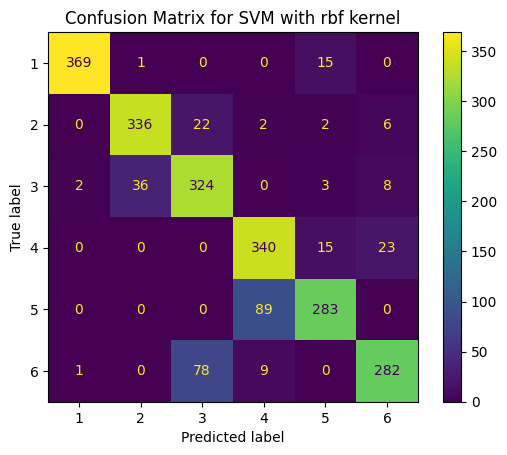

Kernel: linear
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.97      0.98       385
           2       0.89      0.90      0.90       368
           3       0.76      0.83      0.79       373
           4       0.77      0.84      0.80       378
           5       0.84      0.78      0.81       372
           6       0.85      0.74      0.79       370

    accuracy                           0.85      2246
   macro avg       0.85      0.85      0.85      2246
weighted avg       0.85      0.85      0.85      2246

Model with linear kernel saved as models/linear_svm_1.pkl



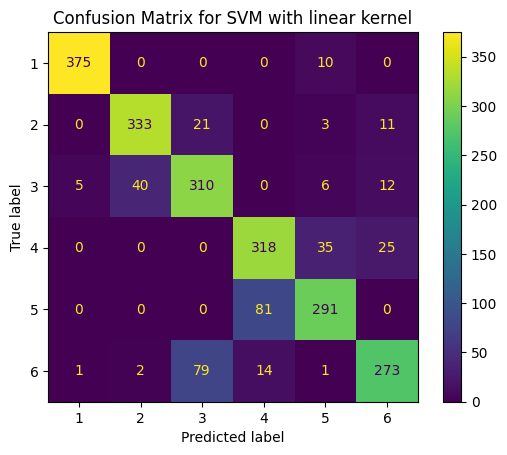

Kernel: poly
Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.90      0.94       385
           2       0.89      0.84      0.86       368
           3       0.78      0.77      0.77       373
           4       0.80      0.84      0.82       378
           5       0.78      0.81      0.80       372
           6       0.74      0.81      0.77       370

    accuracy                           0.83      2246
   macro avg       0.83      0.83      0.83      2246
weighted avg       0.83      0.83      0.83      2246

Model with poly kernel saved as models/poly_svm_1.pkl



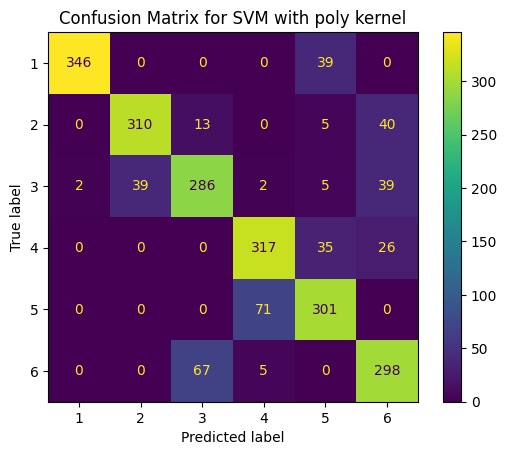

Kernel: sigmoid
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93       385
           2       0.65      0.77      0.70       368
           3       0.75      0.45      0.57       373
           4       0.73      0.66      0.69       378
           5       0.68      0.73      0.70       372
           6       0.63      0.76      0.69       370

    accuracy                           0.72      2246
   macro avg       0.73      0.72      0.71      2246
weighted avg       0.73      0.72      0.72      2246

Model with sigmoid kernel saved as models/sigmoid_svm_1.pkl



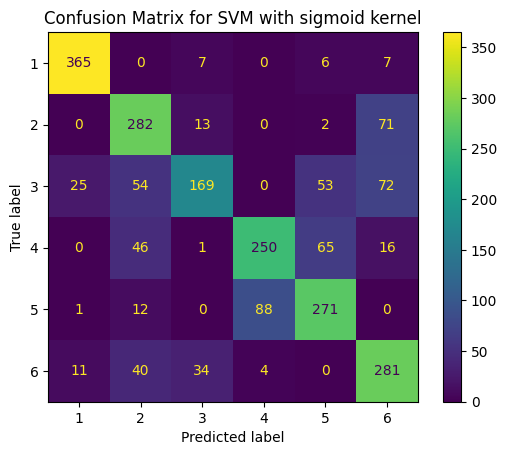

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

# Define the directory and base filename
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Define the different kernels to train

kernels = ['rbf','linear', 'poly', 'sigmoid']



# Iterate over each kernel type
for kernel in kernels:
    # Initialize the SVM model with the specified kernel
    svm_model = SVC(kernel=kernel,tol=1e-4,C=1)
    
    # Train the model on the PCA-reduced training data
    svm_model.fit(X_train, y_train)
    
    # Make predictions on the PCA-reduced test data
    y_pred = svm_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Kernel: {kernel}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    
    # Prepare the model filename with kernel name
    version = 1
    while True:
        model_filename = f"{kernel}_svm_{version}.pkl"
        model_path = os.path.join(model_dir, model_filename)
        if not os.path.exists(model_path):
            break
        version += 1

    # Save the model and training loss
    with open(model_path, 'wb') as f:
        pickle.dump({'model': svm_model}, f)

    print(f"Model with {kernel} kernel saved as {model_path}\n")
    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test)
    plt.title(f'Confusion Matrix for SVM with {kernel} kernel')
    plt.show()


In [58]:

# Define the directory and base filename
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Define the different neighbor values to train
neighbor_values = [3, 7, 12]  # You can add more values as needed

# Iterate over each neighbor value
for n_neighbors in neighbor_values:
    # Initialize the KNN model with the specified number of neighbors
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the model on the PCA-reduced training data
    knn_model.fit(X_train, y_train)
    
    # Make predictions on the PCA-reduced test data
    y_pred = knn_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Number of Neighbors: {n_neighbors}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    
    # Prepare the model filename with n_neighbors
    version = 1
    while True:
        model_filename = f"knn_{n_neighbors}_neighbors_{version}.pkl"
        model_path = os.path.join(model_dir, model_filename)
        if not os.path.exists(model_path):
            break
        version += 1

    # Save the model
    with open(model_path, 'wb') as f:
        pickle.dump({'model': knn_model}, f)

    # print(f"Model with {n_neighbors} neighbors saved as {model_path}\n")
    # Plot the confusion matrix
    # ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test)
    # plt.title(f'Confusion Matrix for KNN with {n_neighbors} neighbors')
    # plt.show()


Number of Neighbors: 3
Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.98      0.97       385
           2       0.83      0.75      0.79       368
           3       0.67      0.74      0.70       373
           4       0.74      0.87      0.80       378
           5       0.85      0.70      0.77       372
           6       0.76      0.73      0.75       370

    accuracy                           0.80      2246
   macro avg       0.80      0.80      0.80      2246
weighted avg       0.80      0.80      0.80      2246

Number of Neighbors: 7
Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.99      0.97       385
           2       0.86      0.76      0.81       368
           3       0.68      0.77      0.72       373
           4       0.75      0.87      0.80       378
           5       0.86      0.71      0.78       372
          

In [55]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# Train the model on the training data
mlp_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the model
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
report_mlp = classification_report(y_test, y_pred_mlp)

print(f"MLP Accuracy: {accuracy_mlp:.2f}")
print("MLP Classification Report:")
print(report_mlp)

# Plot the confusion matrix
# ConfusionMatrixDisplay.from_estimator(mlp_model, X_test, y_test)

MLP Accuracy: 0.85
MLP Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       385
           2       0.91      0.89      0.90       368
           3       0.77      0.84      0.80       373
           4       0.74      0.88      0.81       378
           5       0.86      0.74      0.80       372
           6       0.83      0.77      0.80       370

    accuracy                           0.85      2246
   macro avg       0.85      0.85      0.85      2246
weighted avg       0.85      0.85      0.85      2246

